#### rasterio: 栅格数据处理

In [ ]:
import numpy as np 
import rasterio as rio
from rasterio import mask
from pprint import pprint
import geopandas as gpd
import matplotlib.pyplot as plt
from rasterio import features     ### 需要单独导入


In [20]:
path_img = 'data/Section-6/s2_kunming_chenggong_6bands_20m.tif'


1. 数据读写, 数据写出以MNDWI指数值影像为例。

In [21]:
rsimg = rio.open(path_img)
pprint(rsimg.crs)
pprint(rsimg.meta)


CRS.from_wkt('PROJCS["WGS 84 / UTM zone 48N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",105],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')
{'count': 6,
 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 48N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",105],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'),


In [22]:
rsimg_arr = rsimg.read()
rsimg_arr = np.int16(rsimg_arr)    ### 一般处理数据为有符号整型

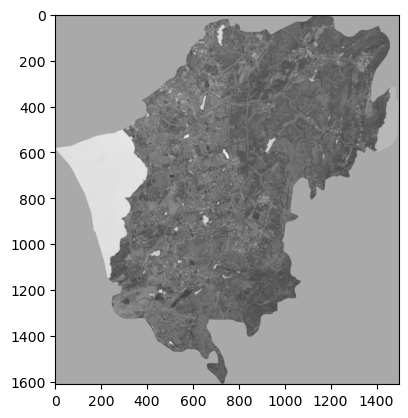

In [23]:
## 指数值计算
mndwi = (rsimg_arr[1]-rsimg_arr[4])/(rsimg_arr[1]+rsimg_arr[4]+0.0001)
plt.imshow(mndwi, cmap='gray')


In [24]:
## 数据写出
path_out = 'data/Section-6/s2_kunming_chenggong_mndwi.tif'
with rio.open(path_out, 'w', driver=rsimg.driver, 
                   height=rsimg.height,
                   width=rsimg.width,
                   count=1,
                   dtype=np.float32,
                   crs=rsimg.crs,
                   transform=rsimg.transform) as dst:
  dst.write(mndwi, 1)       ## the number 1 is the number of bands.


2. 矢量数据栅格化


In [31]:
path_vec = 'data/Section-6/s2_chenggong_mndwi_thre01_poly.gpkg'   ### 水体提取结果
path_rsimg = 'data/Section-6/s2_kunming_chenggong_6bands_20m.tif'    ## 呈贡区遥感影像


In [26]:
### 栅格数据与矢量数据读入
rsimg_rio = rio.open(path_rsimg)
rsimg_arr = rsimg_rio.read()
print(rsimg_arr.shape)
vec_gpd = gpd.read_file(path_vec)
print(vec_gpd.head())


(6, 1611, 1497)
   DN                                           geometry
0   1  POLYGON ((292380.000 2764720.000, 292380.000 2...
1   1  POLYGON ((292360.000 2764680.000, 292360.000 2...
2   1  POLYGON ((282120.000 2764660.000, 282120.000 2...
3   1  POLYGON ((284080.000 2764640.000, 284080.000 2...
4   1  POLYGON ((283160.000 2764400.000, 283160.000 2...


<Axes: >

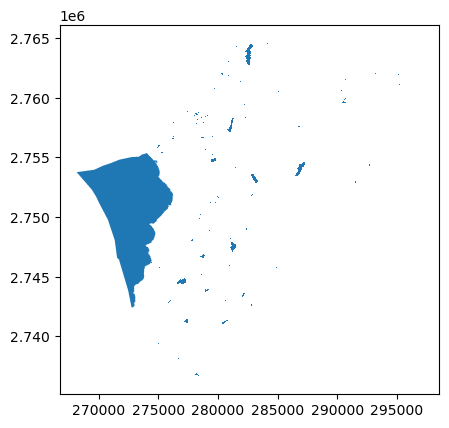

In [32]:
vec_gpd.plot()


In [29]:
### 矢量数据栅格化
vec_to_raster = features.rasterize(shapes = vec_gpd.geometry,
                                out_shape = rsimg_arr[0].shape, ## 栅格行列与所提供遥感影像一致
                                default_value = 1,
                                fill = 0,
                                transform = rsimg_rio.transform,
                                dtype = None)


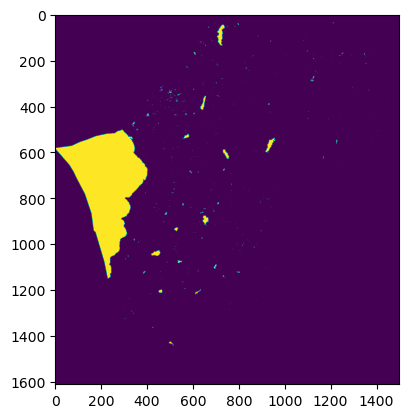

In [30]:
plt.imshow(vec_to_raster)

3. 栅格数据矢量化

In [41]:
path_raster = 'data/Section-6/s2_chenggong_mndwi_thre01_poly2raster.tif'
raster_rio = rio.open(path_raster)
pprint(raster_rio.meta)
raster_arr = raster_rio.read(1)
print(raster_arr.shape)
raster_arr = np.float32(raster_arr)  ## 改代码根据后续报错添加

{'count': 1,
 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 48N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",105],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'),
 'driver': 'GTiff',
 'dtype': 'float64',
 'height': 1000,
 'nodata': None,
 'transform': Affine(28.94, 0.0, 268180.0,
       0.0, -28.16, 2764720.0),
 'width': 1000}
(1000, 1000)


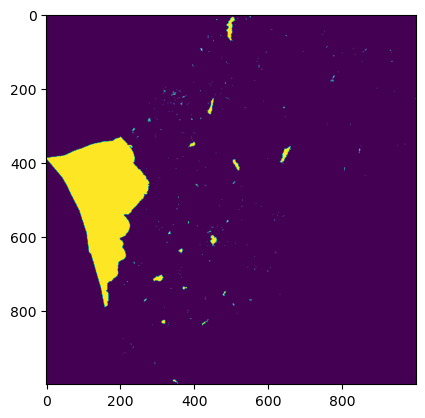

In [42]:
plt.imshow(raster_arr)


In [52]:
from shapely.geometry import shape 

values, geos = [], []
for geo, value in features.shapes(raster_arr, transform=raster_rio.transform):
  # if value == 10:  ## 筛选水体
  values.append(value)  
  geos.append(geo)
geos = [shape(geo) for geo in geos]   ### geojson -> shapely geometry
dict = {'DN': values, 
        'geometry': geos}
region_gpd = gpd.GeoDataFrame(dict, crs="EPSG:32648")
region_gpd.head()

,DN,geometry
0,10.0,"POLYGON ((292373.840 2764720.000, 292373.840 2..."
1,10.0,"POLYGON ((284068.060 2764635.520, 284068.060 2..."
2,10.0,"POLYGON ((284125.940 2764551.040, 284125.940 2..."
3,10.0,"POLYGON ((283170.920 2764410.240, 283170.920 2..."
4,10.0,"POLYGON ((283807.600 2764353.920, 283807.600 2..."


<Axes: >

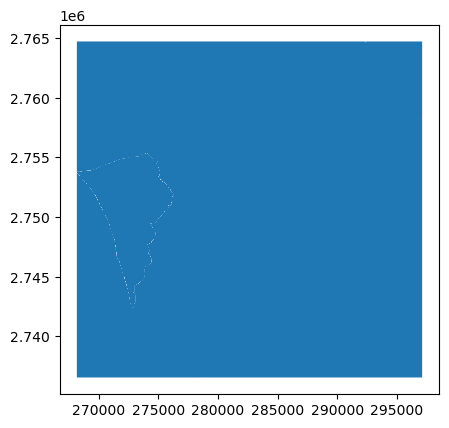

In [53]:
region_gpd.plot()


4. 矢量裁剪

In [ ]:
path_rsimg = 'data/Section-6/s2_kunming_chenggong_6bands_20m.tif'    ## 呈贡区遥感影像
path_vec = 'data/Section-6/subset.gpkg'
path_subset = 'data/Section-6/s2_kunming_chenggong_6bands_20m_subs.tif' 


In [86]:
rsimg_rio = rio.open(path_img)
pprint(rsimg_rio.meta)
vec_gpd = gpd.read_file(path_vec)
vec_gpd = vec_gpd.to_crs(32648)
print(vec_gpd.crs)

{'count': 6,
 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 48N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",105],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'),
 'driver': 'GTiff',
 'dtype': 'uint16',
 'height': 1611,
 'nodata': None,
 'transform': Affine(20.0, 0.0, 268180.0,
       0.0, -20.0, 2765440.0),
 'width': 1497}
EPSG:32648


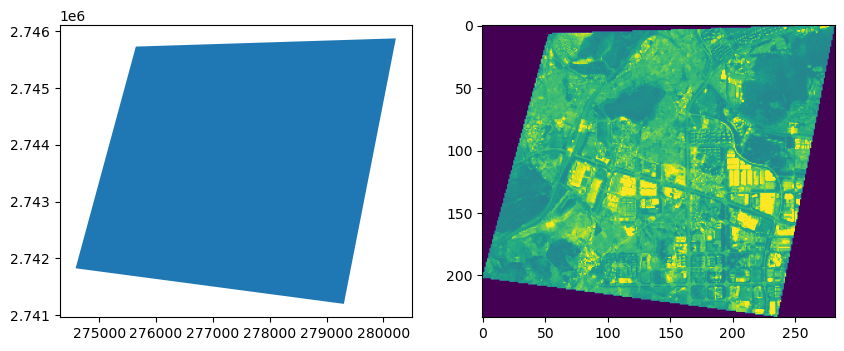

In [87]:
rsimg_sub,rsimg_sub_trans = mask.mask(rsimg_rio, vec_gpd.geometry, crop=True, nodata=0)
fig, ax = plt.subplots(1,2,figsize=(10,5))
vec_gpd.plot(ax = ax[0])
ax[1].imshow(rsimg_sub[0], vmin=0, vmax=3000)


In [88]:
## 写出裁剪影像
out_meta = rsimg_rio.meta
out_meta.update({'driver': 'GTiff',
                        'height': rsimg_sub.shape[1],
                        'width': rsimg_sub.shape[2],
                        'transform': rsimg_sub_trans})
with rio.open(path_subset, 'w', **out_meta) as dset:
    dset.write(rsimg_sub)


5. 影像拼接

In [ ]:
path_reg1 = 'data/Section-6/s2_kunming_chenggong_6bands_20m_subs.tif' 
path_reg2 = 'data/Section-6/s2_kunming_chenggong_6bands_20m_subs2.tif' 


In [93]:
rsimg_reg1_rio = rio.open(path_reg1)
rsimg_reg2_rio = rio.open(path_reg2)


In [94]:
from rasterio.merge import merge

mosaic, out_trans = merge([rsimg_reg1_rio, rsimg_reg2_rio])


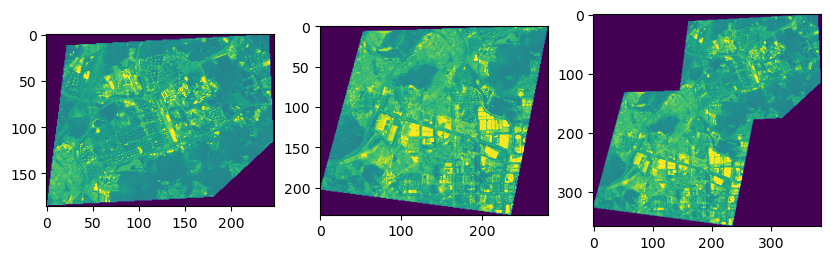

In [95]:
fig, ax= plt.subplots(1,3,figsize=(10,5))
ax[0].imshow(rsimg_reg1_rio.read(1), vmin=0, vmax=3000)
ax[1].imshow(rsimg_reg2_rio.read(1), vmin=0, vmax=3000)
ax[2].imshow(mosaic[0], vmin=0, vmax=3000)


重投影?